# Project: Creating Customer Segments
## Goal: Using Unsupervised Learning Techniques to Perform Customer Segmentation for a Wholesale Distributor

In this project, we analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display # Allows the use of display() for DataFrames

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, we explore the data through visualizations and code to understand how each feature is related to the others. We observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which we track through the course of this project.

Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**.

In [2]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [3]:
# Select three indices to sample from the dataset
indices = [0,200,401]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,3067,13240,23127,3941,9959,731
2,27167,2801,2128,13223,92,1902


Based on the numbers above we start by formulating the following hypothesis for each sample:

Sample point 0: This establishment shows a close-to-average consumption in all product categories except frozen. This could be a local grocery store or a market in a city where people usually purchase fresh products and grocery items when they do not have time to visit a larger and cheaper retailer.

Sample point 1: This establishment shows a relatively low consumption in fresh and delicatessen products (below the 1st quartile) while illustrating really high consumption of groceries, milk and detergents and paper products (above 3rd quartile in all of them). This could be a large retailer that people like for their low prices but do not usually buy food from.

Sample point 2: This establishment shows a really high consumption of fresh, frozen and delicatessen products (above 3rd quartile) while having a low consumption in all other product categories. This could be a restaurant.

### Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In [4]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
for drop_feat in data.keys():
    # Make a copy of the DataFrame, using the 'drop' function to drop the given feature
    new_data = data.drop(drop_feat,axis=1)

    # Split the data into training and testing sets using the given feature as the target
    X_train, X_test, y_train, y_test = train_test_split(new_data, data[drop_feat], test_size = 0.25, random_state = 1)

    # Create a decision tree regressor and fit it to the training set
    regressor = DecisionTreeRegressor(random_state = 1)
    regressor.fit(X_train,y_train)

    # Report the score of the prediction using the testing set
    score = regressor.score(X_test,y_test)

    print "By removing feature {} we achieved a score of {}".format(drop_feat,score)

By removing feature Fresh we achieved a score of -0.923373659298
By removing feature Milk we achieved a score of 0.515849943807
By removing feature Grocery we achieved a score of 0.795768311576
By removing feature Frozen we achieved a score of -0.649574327334
By removing feature Detergents_Paper we achieved a score of 0.815241279195
By removing feature Delicatessen we achieved a score of -0.429125195659


We managed to predict the Grocery and the Detergents and Papers categories with a good accuracy by using the other features. This means that both of these features are not really necessary, we could use one of these two and get the same results.  These two categories are probably highly correlated to each other. We can test that by dropping both categories and then try to guess each of these two categories without using the other.

In [5]:
dropping = ['Grocery','Detergents_Paper']
new_data = data.drop(dropping,axis=1)
for feat in dropping:

    X_train, X_test, y_train, y_test = train_test_split(new_data, data[feat], test_size = 0.25, random_state = 1)

    regressor = DecisionTreeRegressor(random_state = 1)
    regressor.fit(X_train,y_train)

    score = regressor.score(X_test,y_test)

    print "We achieved a score of {} in predicting {}".format(score, feat)

We achieved a score of 0.462211138924 in predicting Grocery
We achieved a score of -0.0999420095066 in predicting Detergents_Paper


Indeed the score of both categories dropped and for Detergents_Paper it became negative. Grocery still maintained a positive score and this is probably because it is correlated to the category Milk. Dropping the category Detergents_Paper or the Grocery category should not affect our results since we could derive their values using the other features.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. We can do that using a scatter matrix.

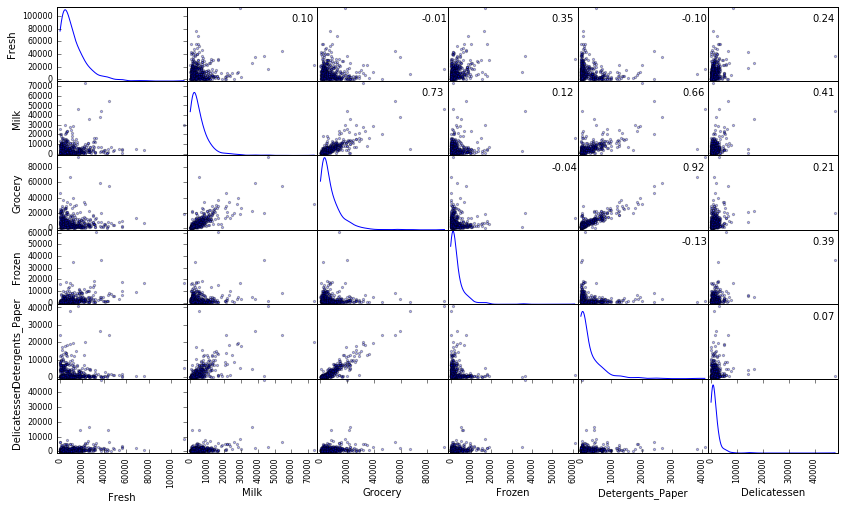

In [6]:
# Produce a scatter matrix for each pair of features in the data
axes = pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

# Reformat data.corr() for plotting
corr = data.corr().as_matrix()

# Plot scatter matrix with correlations
for i,j in zip(*np.triu_indices_from(axes, k=1)):
    axes[i,j].annotate("%.2f"%corr[i,j], (0.8,0.8), xycoords='axes fraction')

Our suspicions are now confirmed that there is correlation between the categories Grocery and Detergents_Paper and Grocery and Milk. The data of all features seems to be skewed positive or Log Normal. If we apply a transformation to the data we can bring it closer to look normally distributed.

## Data Preprocessing
In this section, we preprocess the data to create a better representation of customers by performing a scaling on the data and removing outliers.

### Feature Scaling
Since our data is not normally distributed, it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

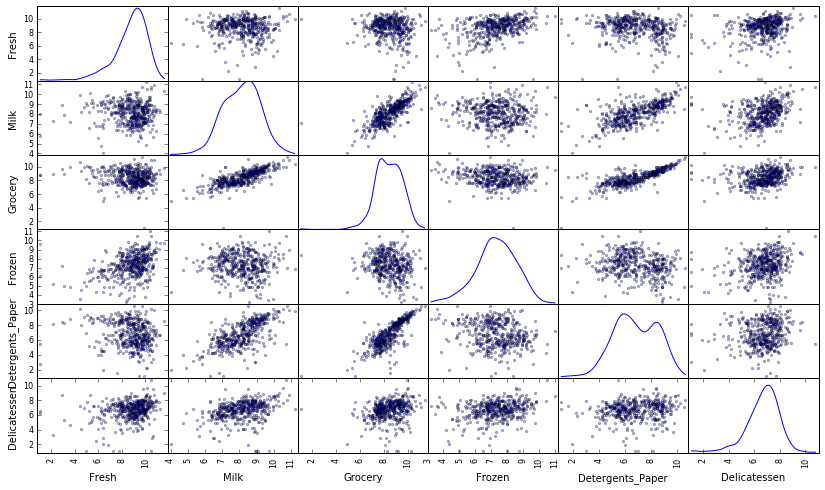

In [7]:
# Scale the data using the natural logarithm
log_data = np.log(data)

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

After applying a natural logarithm scaling to the data, the distribution of each feature appears much more normal.

### Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In [8]:
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature],25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature],75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
# Select the indices for data points you wish to remove
outliers  = [154]

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


Based on the definition above, the datapoints with indexes: 65, 66, 75, 128 and 154 are considered outliers for more than one feature. Taking a look at the original values of these points before feature scaling (see below) we see that all these establishments have very small purchases in one or more categories. We cannot be sure that this is a mistake since all of them (except 154) have at least one category where they made significant purchases. On the other hand the **datapoint with index 154** shows an establishment that did not make any significant purchases. This is not necessarily a mistake in the data but we will have a difficulty matching it in any of the clusters that we will later create because there are no significant purchases performed. In addition, our client is probably not interested in establishment that have not made big purchases (given that there aren't many of them). Therefore, datapoint 154 will be removed.

In [9]:
display(data.loc[[65, 66, 75, 128, 154]])

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,85,20959,45828,36,24231,1423
66,9,1534,7417,175,3468,27
75,20398,1137,3,4407,3,975
128,140,8847,3823,142,1062,3
154,622,55,137,75,7,8


## Feature Transformation
In this section we use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

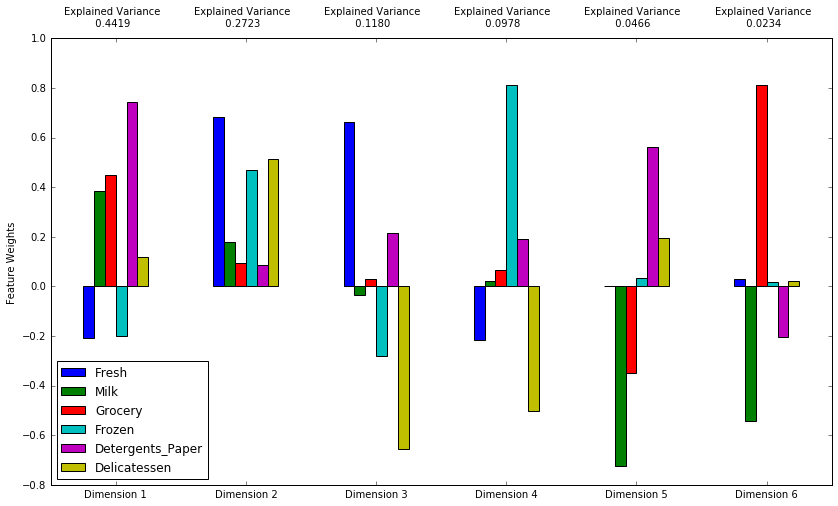

In [10]:
from sklearn.decomposition import PCA

# Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components = 6)
pca.fit(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
def pca_results_vis(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)


pca_results = pca_results_vis(good_data, pca)

The first principal component explains 0.4419 of the variance and the second explains 0.2723, thus, in total, the first two components explain **0.7142** of the variance. The first four principal components explain 0.93 of the variance. 

The first dimension seems to be mostly comprised of the 3 categories that we identified earlier as correlated (i.e. Milk, Grocery and Detergents_Paper) with positive weights and less so by Fresh and Frozen with negative weights. This dimension could represent household staples products that are purchased together. The seond dimension correlates with high positive weights for Fresh, Frozen and Delicatessen products and lower positive weights for the rest. This dimension is mostly correlated with food products. The third dimension is made up of large positive weight for Fresh products and Detergents_Paper and also correlates negatively with Delicatessen and Frozen products. This pattern might represent high end restaurants or fruit markets. Finally, the fourth dimension correlates positively with Frozen products and negatively with Delicatessen and Fresh products. This could represent cheaper restaurants

### Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In [11]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components = 2)
pca.fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

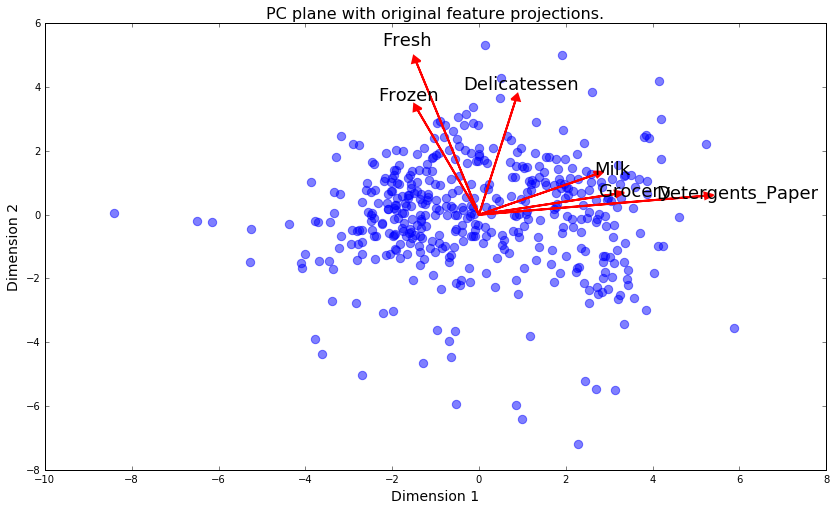

In [12]:
def biplot(good_data, reduced_data, pca):
    '''
    Produce a biplot that shows a scatterplot of the reduced
    data and the projections of the original features.
    
    good_data: original data, before transformation.
               Needs to be a pandas dataframe with valid column names
    reduced_data: the reduced data (the first two dimensions are plotted)
    pca: pca object that contains the components_ attribute

    return: a matplotlib AxesSubplot object (for any additional customization)
    '''

    fig, ax = plt.subplots(figsize = (14,8))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], 
        facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax

biplot(good_data, reduced_data, pca)

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

## Clustering

In this section, we choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. We then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale.

K-Means is a very simple algorithm in implementation and it works well most of the time except if our clusters are elongated or have irregular shapes (assumption for convex and isotropic clusers). A Gaussian Mixture Model is a soft clustering method that performs a Maximum Likelihood estimation assuming a Gaussian distribution. This can be more computationally expensive than K-Means (particularly because of the calculation of the expectation) but it will not bias the clusters to have a specific structure. Given the Biplot visualization above, we see that there is no clear indication for the number of clusters and their shape, thus a soft clustering approach (i.e. Gaussian Mixture Model) seems more reasonable. Nevertheless, we can try both and see what works better. Both algorithms require that we set the number of clusters and for this we will test different cluster numbers for each algorithm and peak the best based on the silhouette score.

### Creating Clusters
As we said above, for this problem the number of clusters is not known *a priori* and therefore there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In [13]:
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.metrics import silhouette_score

for n in [2,3,4,5]:
    for clusterer in [KMeans(n_clusters = n, random_state = 1), GMM(n_components = n, random_state = 1)]:
        # Apply your clustering algorithm of choice to the reduced data 
        
        clusterer.fit(reduced_data)

        # Predict the cluster for each data point
        preds = clusterer.predict(reduced_data)

        # Find the cluster centers
        if clusterer.__module__ == 'sklearn.cluster.k_means_':
            centers = clusterer.cluster_centers_
        # For GMM
        else:
            centers = clusterer.means_

        # Predict the cluster for each transformed sample data point
        sample_preds = clusterer.predict(pca_samples)

        # Calculate the mean silhouette coefficient for the number of clusters chosen
        score = silhouette_score(reduced_data, preds)
        print "{} \n Score for n_clusters = {} is: {:.4f}".format(clusterer,n,score)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0) 
 Score for n_clusters = 2 is: 0.4224
GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=1,
  thresh=None, tol=0.001, verbose=0) 
 Score for n_clusters = 2 is: 0.3952
KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0) 
 Score for n_clusters = 3 is: 0.3969
GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=3, n_init=1, n_iter=100, params='wmc', random_state=1,
  thresh=None, tol=0.001, verbose=0) 
 Score for n_clusters = 3 is: 0.3910
KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0) 
 Score for n_clu

### Tabular Results

The results are summarized below:

| Algorithm | Silhouette Score (n_clusters = 2) |  Silhouette Score (3) | Silhouette Score (4) | Silhouette Score (5) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| K-Means | 0.4224 |  0.3969 | 0.3300 | 0.3496 |
| Gaussian Mixture Model | 0.3952 | 0.3910 | 0.2957 | 0.2682 |

The K-Means algorithm for 2 clusters seems to have the best silhouette score. Now, we will use that algorithm to cluster our data.

In [14]:
# Apply your clustering algorithm of choice to the reduced data 
clusterer = KMeans(n_clusters = 2, random_state = 1)
clusterer.fit(reduced_data)

# Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# Find the cluster centers

centers = clusterer.cluster_centers_

# Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

# Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)

### Cluster Visualization

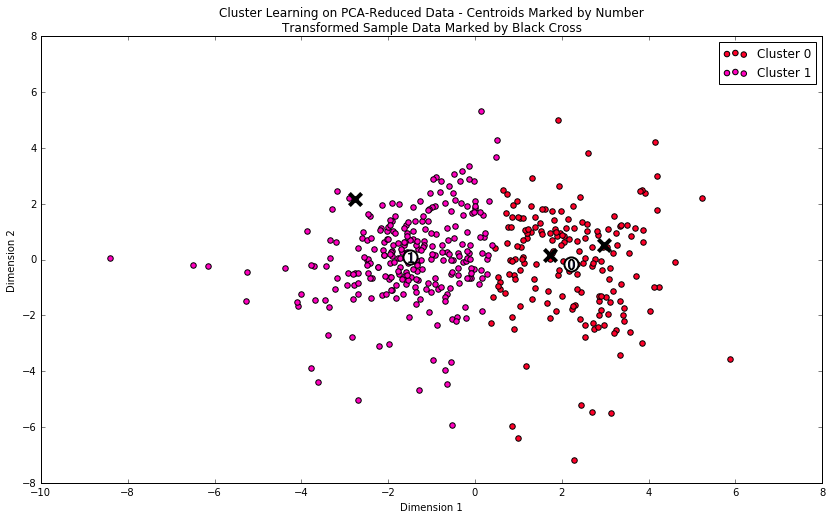

In [15]:
# Display the results of the clustering from implementation
def cluster_results(reduced_data, preds, centers, pca_samples):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions
    Adds cues for cluster centers and student-selected sample data
    '''

    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, reduced_data], axis = 1)

    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))

    # Color map
    cmap = cm.get_cmap('gist_rainbow')

    # Color the points based on assigned cluster
    for i, cluster in plot_data.groupby('Cluster'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                     color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

    # Plot centers with indicators
    for i, c in enumerate(centers):
        ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

    # Plot transformed sample points 
    ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
               s = 150, linewidth = 4, color = 'black', marker = 'x');

    # Set plot title
    ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");


cluster_results(reduced_data, preds, centers, pca_samples)

### Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we recover the representative customer spending from these data points by applying the inverse transformations.

In [16]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,3575.0,7761.0,12516.0,892.0,4610.0,964.0
Segment 1,9047.0,1943.0,2400.0,2113.0,296.0,695.0


The customer segment 0 shows a high consumption in Groceries, Milk and Detergents and Paper. These establishment are probably large and small grocery stores or retailers in generals. Segment 1 shows high consumption of Fresh and frozen products, which should correspond to restaurants or other facilities that handle food.

In [17]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred
display(samples)

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 1


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,3067,13240,23127,3941,9959,731
2,27167,2801,2128,13223,92,1902


As we said initially we expected that our first two sample points correspond to retailers or grocery stores (small and large respectively). Our last sample point was expected to represent a restaurant. Our clustering results seem to be consistent with our initial guess.

More specifically, sample point 0 has close-to-average consumption for all product categories except Frozen. This mirrors the spending for Segment 0 except for the spending in Fresh categories that is significantly higher for our sample point. Sample point 1 shows high spending in all categories except Fresh, Frozen and Delicatessen and this mirrors exactly the behavior of the cluster center of segment 0. Sample point 2 shows high consumption only for Fresh, Frozen and Delicatessen products. This is similar to the center point of Segment 1, except that the center illustrates generally lower values for everything (except Detergents_Paper), which is a sign of a smaller establishent.

## Conclusion

### Effect on A/B Testing
If the wholesale distributor was considering, for instance, limiting its delivery service from 5 to 3 days a week, we can use our clustering results to claim that there is a segment of customers that will probably react negatively to this change. Restaurants and other establishments that handle fresh product need more frequent delivery times to receive those fresh products. On the other hand, the retailers will not be affected much by this change and will probably be ok with it (given that they have enough storage space).

To confirm this we can run an A/B test to try a new delivery schedule for part of our clients. Given our intuition about the existence of two distinct client segments, we should make sure that the test group contains enough clients from each of those segments and separate the results in two categories according to their segment in order to draw careful conclusions as we expect a different reaction from each segment. A less confusing way to do it is to run two separate A/B tests, one for each customer segment.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

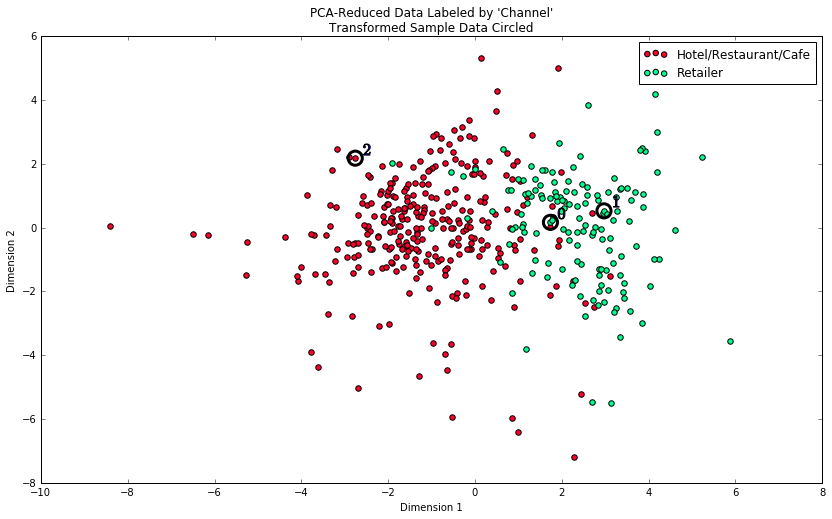

In [18]:
# Display the clustering results based on 'Channel' data
def channel_results(reduced_data, outliers, pca_samples):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions using the full dataset
    Data is labeled by "Channel" and cues added for student-selected sample data
    '''

    # Check that the dataset is loadable
    try:
        full_data = pd.read_csv("customers.csv")
    except:
        print "Dataset could not be loaded. Is the file missing?"
        return False

    # Create the Channel DataFrame
    channel = pd.DataFrame(full_data['Channel'], columns = ['Channel'])
    channel = channel.drop(channel.index[outliers]).reset_index(drop = True)
    labeled = pd.concat([reduced_data, channel], axis = 1)

    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))

    # Color map
    cmap = cm.get_cmap('gist_rainbow')

    # Color the points based on assigned Channel
    labels = ['Hotel/Restaurant/Cafe', 'Retailer']
    grouped = labeled.groupby('Channel')
    for i, channel in grouped:   
        channel.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                     color = cmap((i-1)*1.0/2), label = labels[i-1], s=30);

    # Plot transformed sample points   
    for i, sample in enumerate(pca_samples):
        ax.scatter(x = sample[0], y = sample[1], \
               s = 200, linewidth = 3, color = 'black', marker = 'o', facecolors = 'none');
        ax.scatter(x = sample[0]+0.25, y = sample[1]+0.3, marker='$%d$'%(i), alpha = 1, s=125);

    # Set plot title
    ax.set_title("PCA-Reduced Data Labeled by 'Channel'\nTransformed Sample Data Circled");

channel_results(reduced_data, outliers, pca_samples)

Here we see two clusters appearing with a decision boundary looking like a perpendicular line drawn around the value 0 of the 1st dimension. Close to that boundary there are data points that belong to the opposite cluster segment than the one we identified them belonging to but as we move further away (left or right) from the value 0 of the 1st dimension the results are more purely separated as Retailers and Hotels/Restaurants/Cafes. This classification is consistent with our results and if we had used a Bayesian Mixture Model instead of K-Means, we would have quantified that the probabilities of the retailers we got wrong belonging to the opposite segment are pretty high.